<!-- HTML file automatically generated from DocOnce source (https://github.com/doconce/doconce/)
doconce format html week9.do.txt --no_mako -->
<!-- dom:TITLE: March 20-24, 2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories -->

# March 20-24, 2023: Quantum Computing, Quantum Machine Learning and Quantum Information Theories
**Morten Hjorth-Jensen**, Department of Physics, University of Oslo and Department of Physics and Astronomy and Facility for Rare Isotope Beams, Michigan State University

Date: **March 20-24**

1. Finalize the discussion of the VQE and the Lipkin model

2. [Discussion of the project](https://github.com/CompPhysics/QuantumComputingMachineLearning/tree/gh-pages/doc/Projects/2023/Project1)

## Reminder on the Lipkin model and Variational Quantum Eigensolver (VQE)

[See whiteboard notes from week of March 13-17](https://github.com/CompPhysics/QuantumComputingMachineLearning/blob/gh-pages/doc/HandWrittenNotes/2023/NotesMarch13.pdf) and lecture notes (jupyter-notebook)
from the previous week at <https://github.com/CompPhysics/QuantumComputingMachineLearning/blob/gh-pages/doc/pub/week8/ipynb/week8.ipynb>

## Quantum computing and solving  the eigenvalue problem for the Lipkin model

In [1]:
%matplotlib inline

import numpy as np
import qiskit
from qiskit.visualization import circuit_drawer
from qiskit.quantum_info import Statevector
from matplotlib.pyplot import figure
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer, assemble
from qiskit.providers.aer.noise import NoiseModel
import pylatexenc
from qiskit.algorithms import VQE
from qiskit.utils import QuantumInstance
from qiskit.opflow import X, Z, I, Y
from qiskit.circuit import Parameter
from qiskit.algorithms.optimizers import ADAM
from qiskit.opflow import AerPauliExpectation
from qiskit import IBMQ
import cmath
import pandas as pd
from scipy.sparse import diags
import numpy.linalg as LA
import matplotlib.pyplot as plt
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
pi=np.pi

We turn now to a simpler Lipkin model without the $W$-term and a total spin of $J=1$ as maximum value of the spin, with a Hamiltonian

<!-- Equation labels as ordinary links -->
<div id="_auto1"></div>

$$
\begin{equation}
     \hat{H}_{LM} = \epsilon\hat{J}_z -\frac{1}{2}V(\hat{J}_+\hat{J}_++\hat{J}_-\hat{J}_-).
\label{_auto1} \tag{1}
\end{equation}
$$

The quasi-spin operators act like lowering and raising angular momentum operators, as discussed earlier.
With these properties we can calculate the LM Hamiltonian matrix

<!-- Equation labels as ordinary links -->
<div id="_auto2"></div>

$$
\begin{equation}
\langle JJ_z|H_{LM}|JJ_z'\rangle,
\label{_auto2} \tag{2}
\end{equation}
$$

where the non-zero elements are given by

<!-- Equation labels as ordinary links -->
<div id="_auto3"></div>

$$
\begin{equation}
\begin{split}
    \langle JJ_z|H_{LM}|JJ_z'\rangle & = \epsilon J_z\\
     \langle JJ_z|H_{LM}|JJ_z'\pm 2\rangle & = \langle JJ_z\pm 2|H_{LM}|JJ_z'\rangle \\
     &= -\frac{1}{2}VC,
\end{split}
\label{_auto3} \tag{3}
\end{equation}
$$

where $C$ is the Clebsch-Gordan coefficients one gets when $J_{\pm}^2$ operates on the state $|JJ_z\rangle$.
Using the above definitions  we can calculate the exact solution to the Lipkin model.

The Hamiltonian is given by

<!-- Equation labels as ordinary links -->
<div id="_auto4"></div>

$$
\begin{equation}
\begin{pmatrix}-\epsilon & 0 & -V\\
 0&0&0\\
 -V&0&\epsilon
\end{pmatrix}
\label{_auto4} \tag{4}
\end{equation}
$$

In [2]:
#function that sorts eigenvalues with its eigenvectors in accending order
def eigen(A):
    eigenValues, eigenVectors = LA.eig(A)
    idx = np.argsort(eigenValues)
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]
    return (eigenValues, eigenVectors) 

#one body expectation value
def one_body(E,N):
  k = N/2
  m = np.arange(-k,k+1,1) # Since the collective space is Omega+1
  return E*np.diag(m) #return a matrix where its diagonal elemens are epsilon*K_0

#two body expectation value
def two_body(V,N):
  k = N/2
  m = np.arange(-k,k+1,1)
  left =np.zeros(len(m)-2,dtype=complex)
  right = np.zeros(len(m)-2,dtype=complex)
  diag = np.zeros(len(m),dtype=complex)
  for i in range(len(left)):
    CG = cmath.sqrt(k*(k+1)-(m[i]+2)*(m[i]+1))*cmath.sqrt(k*(k+1)-m[i]*(m[i]+1)) #calculate Clebsch-Gordan Coefficients 
    left[i] = CG
    right[i] = CG
  k = [left,diag,right]
  offset = [-2,0,2]
  return -0.5*V*diags(k,offset).toarray() #return a matrix where its off digonal elements are (1/2)V(K^2_+ + K^2_-)

#full expectation value
def quasi_spin(E,V,N):
  ob = one_body(E,N)
  tb = two_body(V,N)
  H = ob+tb 
  e,v = eigen(H) # find the eigenvalues of the Hamiltonian
  return e,H

#converts chi to V
def Vp(E,omega,chi):
  return (chi*E)/(omega-1)

In [3]:
#parameters
E = 1
chi = np.arange(0,2.1,0.1)
omega = 2

EV0 = []
EV1 = []
EV2 = []
Ham = []
for i in chi:
  v = Vp(E,omega,i)
  EigenV,H = quasi_spin(E,v,omega) #return eigenvalues and Hamiltonian
  Ham.append(H)
  EV0.append(EigenV[0])
  EV1.append(EigenV[1])
  EV2.append(EigenV[2])

In [4]:
matrix = pd.DataFrame(Ham[5].real)
print('Hamiltonian matrix')
matrix.head()

Hamiltonian matrix


,0,1,2
0,-1.0,0.0,-0.5
1,0.0,0.0,0.0
2,-0.5,0.0,1.0


Text(0.5, 1.0, '$\\Omega=2$ exact Lipkin Model')

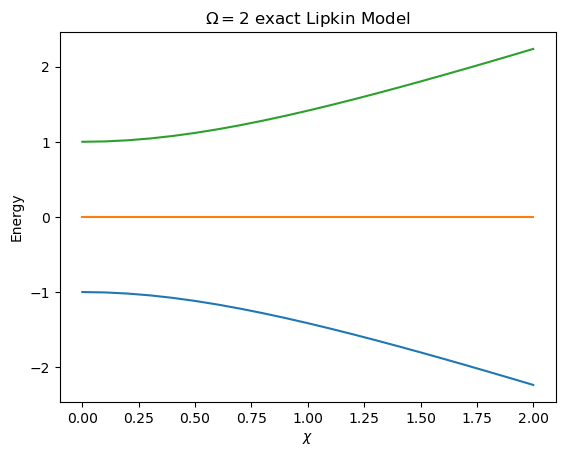

In [5]:
plt.plot(chi,EV0)
plt.plot(chi,EV1)
plt.plot(chi,EV2)
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.title('$\Omega=2$ exact Lipkin Model')

### Hartree Fock

A variational method in quantum mechanics, starts with the Schrodinger equation where one minimizes the energy for a given trail wave function $|\psi\rangle$.

<!-- Equation labels as ordinary links -->
<div id="_auto5"></div>

$$
\begin{equation}
\delta\frac{\langle\psi |\hat{H}|\psi\rangle}{\langle\psi|\psi\rangle}=0
\label{_auto5} \tag{5}
\end{equation}
$$

The Hartree Fock (HF) method is a variational method that assumes that
the exact N-body wavefunction of the system can be approimated by a
single Slater determinant, where energy of the system is minimized and
the trial wave function is the particle number conserving coherent
product state. The SU(2) coherent states map a two-dimensional sphere
known as the bloch sphere onto the complex plane,

<!-- Equation labels as ordinary links -->
<div id="_auto6"></div>

$$
\begin{equation}
\tau = tan\frac{\theta}{2}e^{-i\phi}
\label{_auto6} \tag{6}
\end{equation}
$$

where the normalized coherent SU(2) state can be written in the language of LM:

<!-- Equation labels as ordinary links -->
<div id="_auto7"></div>

$$
\begin{equation}
|\tau\rangle = \frac{1}{(1+|\tau|^2)^{\Omega/2}}e^{\tau\hat{K}_+}|\frac{\Omega}{2},-\frac{\Omega}{2}\rangle,
\label{_auto7} \tag{7}
\end{equation}
$$

The $E_{g.s}$ of the LM given HF coherent states is:

<!-- Equation labels as ordinary links -->
<div id="_auto8"></div>

$$
\begin{equation}
E(\tau) = \langle \tau|\hat{H}_{LM}|\tau\rangle.
\label{_auto8} \tag{8}
\end{equation}
$$

To calculate equation the last euation, we use generating functions for:

<!-- Equation labels as ordinary links -->
<div id="_auto9"></div>

$$
\begin{equation}
\begin{split}
\langle \tau|\hat{J}_{z}|\tau\rangle &= \frac{1}{2}\Omega\frac{|\tau|^2-1}{\tau|^2+1}\\
\langle \tau|\hat{J}_{\pm}^2|\tau\rangle &= \Omega\frac{\tau^*}{|\tau|^2+1}
\end{split}
\label{_auto9} \tag{9}
\end{equation}
$$

Then using the definition of $\tau$ in equation (10) we can write down the energy:

<!-- Equation labels as ordinary links -->
<div id="_auto10"></div>

$$
\begin{equation}
E(\tau) = -\frac{\epsilon}{2}\Omega(cos\theta+\frac{\chi}{2}sin^2\theta cos2\phi),
\label{_auto10} \tag{10}
\end{equation}
$$

where $\chi=\frac{V}{\epsilon}(\Omega-1)$. Minimizing $E(\tau)$ with respect to $\theta,\phi$, we obtain the ground state Hartree Fock energy

<!-- Equation labels as ordinary links -->
<div id="_auto11"></div>

$$
\begin{equation}
\begin{split}
E_{HF}  = -\frac{\Omega}{2}\epsilon &\hspace{1cm} \chi<1\\
E_{HF}  = -\frac{\Omega}{4}\epsilon(\chi+\frac{1}{\chi}) &\hspace{1cm} \chi\ge 1
\end{split}
\label{_auto11} \tag{11}
\end{equation}
$$

In [6]:
def E_HF(x,E,omega):
  if x < 1:
    EHF = -(omega/2)*E
  elif x >= 1:
    EHF = -(omega/4)*E*(x+(1/x))
  return EHF

In [7]:
epsilon = 1
Omega = 2

HF = []
exact = []
for x in chi:
    HF.append(E_HF(x,epsilon,omega).real)
    v = Vp(epsilon,omega,x)
    e,h = quasi_spin(epsilon,v,omega)
    exact.append(e[0].real)

In [8]:
plt.plot(chi,HF,label='HF')
plt.plot(chi,exact,label='exact')
plt.xlabel('$\chi$')
plt.ylabel('Energy')
plt.axvline(1, color = 'k', linestyle='--')
plt.title('$\Omega=2$ exact Lipkin Model')
plt.legend(bbox_to_anchor=(1.05, 1))

### Quantum Circuit

To solve the Lipkin model on a quantum computer we have to solve Schrodinger's equation.

<!-- Equation labels as ordinary links -->
<div id="_auto12"></div>

$$
\begin{equation}
H|\psi(\tilde{\theta})\rangle = E|\psi(\tilde{\theta})\rangle\\
\label{_auto12} \tag{12}
\end{equation}
$$

We map the creation and annihilation operators to Pauli spin matrices/operators Z, X, Y (show this). The Hamiltonian then takes the form of

<!-- Equation labels as ordinary links -->
<div id="_auto13"></div>

$$
\begin{equation}
H = \frac{\epsilon}{2}(Z_0\otimes \boldsymbol{I}_1+Z_1\otimes \boldsymbol{I}_0) - \frac{V}{2}(X_0\otimes X_1 + Y_0\otimes Y_1),
\label{_auto13} \tag{13}
\end{equation}
$$

where the Pauli operators are the measurement basis which the quantum
circuit is measured in. The subscripts refer to quibits $0$ and $1$ respectively. Since we have two particles in this case, we end up with a two qubit state, as indicated
in the ansatz for the initial state here.
The Hamiltonian can thus we rewritten as a $4\times 4$ matrix acting on a two-qubit state. 

However, before measuring, we first have to
prepare the initial state $\vert\psi(\tilde{\theta})\rangle$ for
$\Omega=2$ of the LM circuit

<!-- Equation labels as ordinary links -->
<div id="_auto14"></div>

$$
\begin{equation}
\vert\psi(\tilde{\theta})\rangle = \cos{ (\tilde{\theta})}\vert 00\rangle+\sin{(\tilde{\theta})}\vert 11\rangle,
\label{_auto14} \tag{14}
\end{equation}
$$

where $|00\rangle =|\uparrow\uparrow\rangle$, $|11\rangle=|\downarrow\downarrow\rangle$, and $\tilde{\theta}=\theta-\frac{\pi}{2}$. 

This type of problem resides in the pantheon of variational methods
where we minimize $\tilde{\theta}$. This problem was coded using IBM's
python library Qiskit. Since this is a variational problem, the use of
Qiskit's Variational Quantum Eigensolver (VQE) was used to find the
optimal $\tilde{\theta}$ that minimizes
$\langle\psi(\tilde{\theta})|H|\psi(\tilde{\theta})\rangle$.

In [6]:
def LM_circuit():
    theta = Parameter('theta')
    QC = QuantumCircuit(2)
    QC.ry(2*(theta-np.pi/2),0)
    QC.cnot(0,1)
    return QC

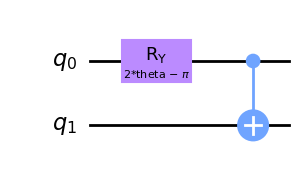

In [7]:
QC = LM_circuit()
QC.draw(output='mpl')

### VQE method

For this method, we will be using Qiskit's VQE function, where we specifiy 
* Quantum circuit

a. Optimizer

b. Quantum instance (i.e. which backend). Here we will be using the "qasm_simulator" 

c. Initial point (i.e. $\theta$ search space)

d. Hamiltonian/measurement basis

To define the Hamiltonian, we will use the Qiskit Pauli operator functions
I,Z,X,Y.  In this method, for a given $\chi$, we will do a search over
$\theta$ from $-\frac{\pi}{2}$ to $\frac{\pi}{2}$ and picking out the
minimum energy value

In [11]:
#sim1 min example
sim = Aer.get_backend('qasm_simulator')
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000) #optimizer for VQE
epsilon = 1
omega = 2
chi2 = [0.5,1]

t = np.arange(-pi/2,pi/2,0.05) #0.1 step size finishs pretty fast
energy = []
for x in chi2:
    ev = []
    v = Vp(epsilon,omega,x)
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) + 0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)
        ev.append(result.eigenvalue)
    energy.append(ev)


plt.plot(t,energy[0],label='$\chi=0.5$')
plt.plot(t,energy[1],label='$\chi=1$')
plt.xlabel('$\\theta$')
plt.ylabel('Ground State Energy')
plt.title('$E_{g.s}$ vs. $\\theta$')
plt.legend()

In [12]:
epsilon = 1
omega = 2
chi3 = np.arange(0,2.1,0.1)
t = np.arange(-pi/2,pi/2,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi3:
    v = Vp(epsilon,omega,x)
    ev = []
    for i in range(len(t)):
        H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z ) -0.5 * v * ( X ^ X ) +0.5 * v * ( Y ^ Y )
        vqe = VQE(ansatz=LM_circuit(),optimizer=adam,initial_point=[t[i]],quantum_instance=sim,expectation=AerPauliExpectation())
        result = vqe.compute_minimum_eigenvalue(H)

        ev.append(result.eigenvalue)
    LM_sim.append(min(ev))

plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi3,LM_sim,label='QC sim',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title(f'$\Omega=2$')
plt.legend()

### VQE method using Qiskit

For this method, we will be using Qiskit's VQE function, where we specifiy 
1. Quantum circuit

2. Optimizer

3. Quantum instance (i.e. which backend). Here we will be using the "statevector_simulator" 

4. Hamiltonian/measurement basis

In [13]:
epsilon = 1
omega = 2
chi5 = np.arange(0,2.1,0.1)
adam =qiskit.algorithms.optimizers.ADAM(maxiter=10000)
LM_sim = []
for x in chi5:
    v = Vp(epsilon,omega,x)
    H = 0.5 * epsilon * ( Z ^ I ) +0.5 * epsilon * ( I ^ Z )-0.5 * v * ( X ^ X ) + 0.5 * v * ( Y ^ Y )
    vec = Aer.get_backend('statevector_simulator')
    vqe = VQE(ansatz=LM_circuit(),optimizer=adam,quantum_instance=vec,expectation=AerPauliExpectation())
    result = vqe.compute_minimum_eigenvalue(H)
    LM_sim.append(result.eigenvalue)


plt.plot(chi,np.array(exact),label='$E_{exact}$',color='b')
plt.plot(chi,np.array(HF),label='$E_{HF}$',color='g')
plt.scatter(chi5,LM_sim,label='QC state vec',color='cyan')
plt.axvline(1, color = 'k', linestyle='--')
plt.ylabel('$E_{g.s}$')
plt.xlabel('$\chi$')
plt.title('$\Omega=2$')
plt.legend()

Typically, running with Qiskit's own VQE is faster.